# Example 1-Coupled Pendula on 2D dataset 

This notebook presents an example walking through all the steps of turning a (simulation of) coupled chain of pendula into a physical neural network that is trained with physics-aware-training.

In Section 1, the experiment class is briefly tested. In Section 2 the experiment is initialized ina way that makes it usable in a physical neural network. In Section 3, a differentiable digital model for the experiment is trained that allows us, in Section 4, to create a physical neural network with the experiment. The network classifies 2-dimensional points of a simple dataset.
As shown in the graph below, 2-dimensional inputs are encoded in the initial angles of the red pendula. The initial position of the orange pendula are trainable parameters of the PNN and the PNN's output is the final angle of the central pendulum after evolving for `Tmax`.
Finally, in Section 5, a multi-layer physical neural network on basis of the coupled pendula experiment is demonstrated.

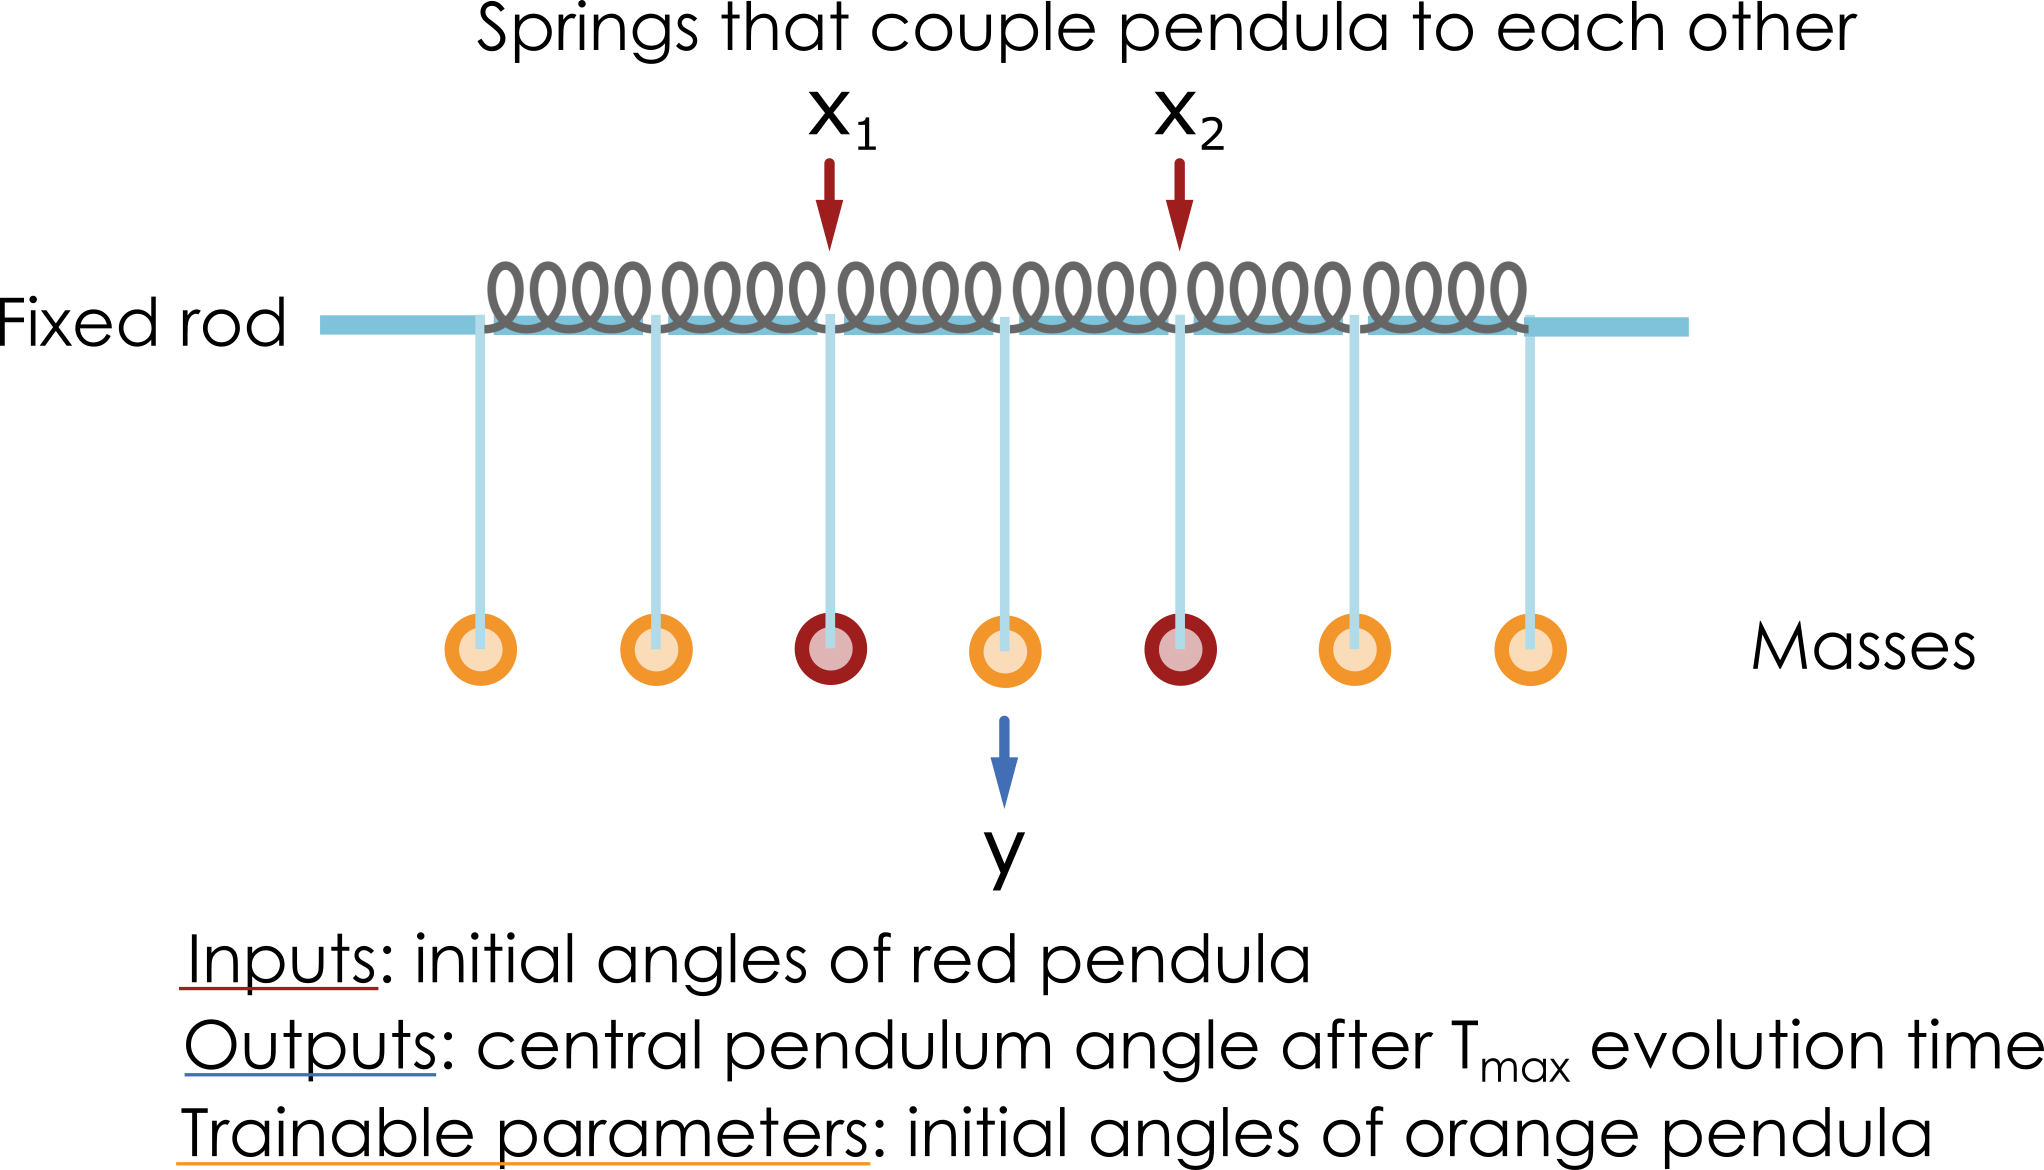

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Test-the-experiment-class" data-toc-modified-id="Test-the-experiment-class-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Test the experiment class</a></span></li><li><span><a href="#Initialize-experiment-as-a-PNN-module" data-toc-modified-id="Initialize-experiment-as-a-PNN-module-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Initialize experiment as a PNN module</a></span></li><li><span><a href="#Train-differentiable-digital-model" data-toc-modified-id="Train-differentiable-digital-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Train differentiable digital model</a></span><ul class="toc-item"><li><span><a href="#(Optional)-Test-digital-twin-on-unseen-data:" data-toc-modified-id="(Optional)-Test-digital-twin-on-unseen-data:-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>(Optional) Test digital twin on unseen data:</a></span></li><li><span><a href="#(Optional)-Explore-physical-systems-expressivity" data-toc-modified-id="(Optional)-Explore-physical-systems-expressivity-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>(Optional) Explore physical systems expressivity</a></span></li></ul></li><li><span><a href="#Single-layer-physical-neural-network" data-toc-modified-id="Single-layer-physical-neural-network-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Single layer physical neural network</a></span><ul class="toc-item"><li><span><a href="#Define-PNN-module" data-toc-modified-id="Define-PNN-module-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Define PNN module</a></span></li><li><span><a href="#Train-PNN-module" data-toc-modified-id="Train-PNN-module-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Train PNN module</a></span><ul class="toc-item"><li><span><a href="#Initialize-simple-dataset" data-toc-modified-id="Initialize-simple-dataset-5.2.1"><span class="toc-item-num">5.2.1&nbsp;&nbsp;</span>Initialize simple dataset</a></span></li><li><span><a href="#Initialize-model,-optimizer-and-scheduler" data-toc-modified-id="Initialize-model,-optimizer-and-scheduler-5.2.2"><span class="toc-item-num">5.2.2&nbsp;&nbsp;</span>Initialize model, optimizer and scheduler</a></span></li><li><span><a href="#Training-loop" data-toc-modified-id="Training-loop-5.2.3"><span class="toc-item-num">5.2.3&nbsp;&nbsp;</span>Training loop</a></span></li></ul></li><li><span><a href="#Visualize-results" data-toc-modified-id="Visualize-results-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Visualize results</a></span></li><li><span><a href="#Save-data" data-toc-modified-id="Save-data-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Save data</a></span></li></ul></li><li><span><a href="#Multilayer-physical-neural-network" data-toc-modified-id="Multilayer-physical-neural-network-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Multilayer physical neural network</a></span><ul class="toc-item"><li><span><a href="#Define-multilayer-architecture" data-toc-modified-id="Define-multilayer-architecture-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Define multilayer architecture</a></span></li><li><span><a href="#Test-on-circle-dataset" data-toc-modified-id="Test-on-circle-dataset-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Test on circle dataset</a></span></li><li><span><a href="#Test-on-stripe-dataset" data-toc-modified-id="Test-on-stripe-dataset-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Test on stripe dataset</a></span></li></ul></li></ul></div>

## Imports

In [1]:
# import parent directory in case it is not part of PYTHONPATH so that we can import physics_aware_training
import sys
sys.path.append("..")

In [2]:
# standard python imports
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import copy

# pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

In [4]:
# determine whether a GPU is available for training
use_cuda = torch.cuda.is_available()
# If a specific GPU should be used, change device name "cuda" to "cuda:0" or whichever number should be used
device = torch.device("cuda" if use_cuda else "cpu")
# set manual seed for replicability
torch.manual_seed(0)

## Test the experiment class

We import an experiment class `CoupledPendula` which is defined in exp.py. Other experimental classes can be used and imported from anywhere else but they need to follow the template lined out in [exp.py](exp.py).

In [5]:
from exp import CoupledPendula

Initialize an instance of the CoupledPendula experiment to test it. The coupled pendula class needs to be initialized with a parameter `Tmax` that determines how long the coupled pendula are evolved in time before measuring the final angles (in seconds):

In [6]:
pend = CoupledPendula(Tmax = 2)

In the following, all parameters required to call an instance of the experiment are defined. These represent the trainable parameters of the experiment and they can vary from sample to sample. Here, two equal sets of parameters are created and the evolution of different initial conditions through the experiment is plotted:

In [7]:
# simulate a chain of coupled pendula with the following parameters
ω0 = torch.tensor([10.,10.]).repeat(2,1)
ωd = torch.tensor([0.,0.]).repeat(2,1)
Ad = torch.tensor([0.,0.]).repeat(2,1)
v0 = torch.tensor([0.,0.]).repeat(2,1)
coupling = torch.tensor([10.,10.]).repeat(2,1)
γ = torch.tensor([0.,0.]).repeat(2,1)
encoding_amplitude = torch.tensor(1.).repeat(2,1)
phid = torch.tensor([0.,0.]).repeat(2,1)

# set initial angles (in rad)
theta_initial = torch.tensor([[1,1],
                  [1,-1,]])

# propagate through setup. The "full=True" parameter determines that the full
# time evolution of the pendula is returned instead of just the final angle.
theta = pend(theta_initial, ω0, ωd, Ad, v0, coupling, γ, encoding_amplitude, phid, full = True)

Instead of executing an experiment, when calling `pend` we simulate a differential equation of coupled pendula:

$$ \frac{d^2 \theta_n}{dt^2} = -\omega_{0n}^2\sin(\theta_n) + c_{n+1} \: (\theta_{n+1} - \theta_n) + c_{n} \: (\theta_{n-1} - \theta_n)$$

$\omega_0n$ is the natural frequency of the $n$-th pendulum and $c_{n}$ is the coupling constant of the $n$-th pendulum to the $(n-1)$-th pendulum.

`theta` is an array containing the full time evolution of the pendula's angle and angular velocity over the whole time of evolution. It is of the shape [number of time steps, batch size, number of pendula, 2]. The final dimension contains the angles (index 0) and angular velocities (index 1). By default the number of timesteps is 30 steps per second.

The following graph shows the angle over time for both initial conditions:

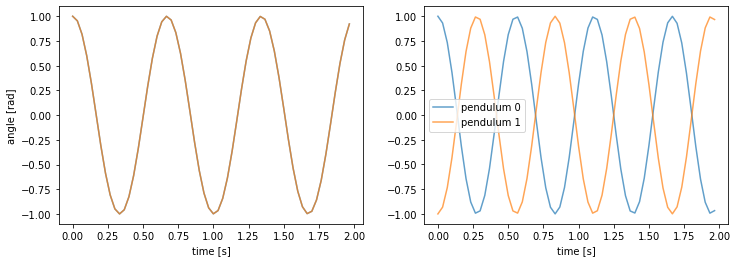

In [8]:
t = torch.arange(0, pend.Tmax, 1/30)

plt.figure(figsize = [12,4])
plt.subplot(1,2,1)
# loop over all pendula
for i in range(2):
    plt.plot(t, theta.detach().cpu()[:, 0, i, 0], alpha = 0.7, label = f'pendulum {i}')
plt.xlabel('time [s]')
plt.ylabel(f'angle [rad]')
    
plt.subplot(1,2,2)
# loop over all pendula
for i in range(2):
    plt.plot(t, theta.detach().cpu()[:, 1, i, 0], alpha = 0.7, label = f'pendulum {i}')
plt.xlabel('time [s]')
plt.legend()

The left graph shows all pendula moving in unison when starting from the same initial conditions.
The right graph shows the pendula swinging exacly out of phase and with increased frequency due to the coupling between them.

## Initialize experiment as a PNN module

In the next step, the coupled pendula experiment is prepared to be used in a physical neural network. Therefore it needs to be initialized as an `ExpModule`. The `ExpModule` stores essential information about the experiment that is needed during training of the PNN: An instance of the experiment to be used for the forward pass, a differentiable digital model--the digital twin--used for the backward pass, the input- and output-dimension of the physical system, all hyperparameters, all trainable parameters and the range of values that these parameters can assume. This generic class is meant to be reused for multiple experiments. It is defined and imported from [modules.py](modules.py):

In [9]:
from physics_aware_training.modules import ExpModule

tensor([0.4963])


The next cell defines and explains all arguments that the ExpModule needs to be initialized. Here we initialize an experiment with 7 pendula that evolve for 2 seconds. We set all trainable parameters to a fixed value as we will use the initial angles of the pendula as trainable parameters.

In [10]:
n_pendula = 7

pendulaargs = dict(
    Exp = CoupledPendula,
    # Inputs are encoded in the initial angles of pendule on the chain. Hence the
    # input dimension is equal to the number of pendula.
    input_dim = n_pendula, 
    # Similarly for the outputs, which correspond to the final angle of the pendula
    output_dim = n_pendula, 
    # We allow the initial angles to be in a range of -90deg to 90deg:
    input_range = [-0.6*np.pi,0.6*np.pi],
    # All hyperparameters and the fixed values they have need to be stored
    # in a dictionary called hparams. The names of the keys in the dictionary
    # need to correspond to the arguments of the experiment's __init__ function.
    # The pendula experiment only has one hyperparameter which is the simulation time.
    # We set it to 2 seconds:
    hparams = dict(
        Tmax = 2.
    ),
    # params_reg is a parameter register that needs the names of
    # all parameters of the experiment and their respective dimension. 
    # The names of the keys in this dictionary need to correspond the arguments
    # of the experiment's __call__ function. 
    # The pendula experiment has some parameters like the natural frequency that 
    # can be adjusted for every single pendulum individually, so their dimension 
    # is equal to the number of pendula. Other parameters are just scalars and
    # their dimension is equal to one.
    params_reg = dict(
       ω0 = [n_pendula],
       ωd = [n_pendula],
       Ad = [n_pendula],
       v0 = [n_pendula],
       coupling = [n_pendula],
       γ = [n_pendula],
       encoding_amplitude = [1],
       phid = [1]),
    # params_range takes the experimentally allowable/realizeable range for each 
    # parameter as a list containing [lower bound, upper bound]. 
    # Bounds need to be set so that 1) during training the PNN does not 
    # produce parameters that are not experimentally realizable and 2) because the
    # differentiable digital model is usually only valid over a finite range of 
    # parameters.
    # By setting the lower bound equal to the upper bound, parameters are effectively
    # converted to hyperparameters and fixed at the respective value during training.
    params_range = {
       'ω0' : [10.,10.],
       'ωd' : [0.,0.],
       'Ad' : [0.,0.],
       'v0' : [0.,0.],
       'coupling' : [20, 20],
       'γ' : [0., 0.],
       'encoding_amplitude' : [1., 1.],
       'T' : [2,2],
       'phid' : [0,0]},
    device = device
)  

# To initialize the pendula as an ExpModule that can be used in a PNN, we pass
# all the above defined arguments to ExpModule.
# By default, the ExpModule loads a deep neural network as a differentiable 
# digital (or trains one if loading fails). The next section shows how to do this
# manually so we set load_dt to False to prevent the automatic training procedure.
pendula = ExpModule(**pendulaargs, load_dt = False)

This instance of `ExpModule` can be treated like a `torch.nn.Module` and be built into a neural network. However, before being able to backpropagate through the `ExpModule`, a differentiable digital model needs to be trained, which was prevented by setting 
```Python
load_dt = False
``` 
so far. This will be done manually in the following section:

## Train differentiable digital model

In [11]:
# Load architecture for differentiable digital model
from physics_aware_training.model_architectures.DNN import DNN, DNNObjective

Taking uniformly distributed data across the inputs and parameters is automatized. By calling `pendula.dt.take_dt_data`, the experiment is executed 50000 times with uniformly distributed inputs and parameters. The inputs, parameters, and outputs to be saved to a file named after the experiment and the hyperparameters.

In [12]:
# take data for digital twin
pendula.dt.take_dt_data(Nx = 50000)

Saved data exp_io_data\CoupledPendula_mean_in7_out7_Tmax2.0_data.npz


With this data, a differentiable digital model can be trained to learn the input-output relation of the experiment. Here, we train a deep neural network, defined in the `DNN` class in the [model_architectures/DNN.py](model_architectures/DNN.py) file. All parameters needed to specify the digital model can be passed to the `pendula.dt.train_mean_dt` function.
For a `DNN`, these are the number of hidden neurons per layer, which are specified in the `Nunits` parameter. The learning rate and number of epochs, among other parameters, can also be specified. 

Loaded data exp_io_data\CoupledPendula_mean_in7_out7_Tmax2.0_data.npz
Epoch: 1, 	 Train loss: 0.17, 	 Test loss: 0.17
Epoch: 2, 	 Train loss: 0.11, 	 Test loss: 0.12
Epoch: 3, 	 Train loss: 0.08, 	 Test loss: 0.09
Epoch: 4, 	 Train loss: 0.07, 	 Test loss: 0.08
Epoch: 5, 	 Train loss: 0.06, 	 Test loss: 0.07
Epoch: 6, 	 Train loss: 0.06, 	 Test loss: 0.06
Epoch: 7, 	 Train loss: 0.05, 	 Test loss: 0.05
Epoch: 8, 	 Train loss: 0.04, 	 Test loss: 0.05
Epoch: 9, 	 Train loss: 0.04, 	 Test loss: 0.05
Epoch: 10, 	 Train loss: 0.04, 	 Test loss: 0.04
Epoch: 11, 	 Train loss: 0.03, 	 Test loss: 0.04
Epoch: 12, 	 Train loss: 0.03, 	 Test loss: 0.04
Epoch: 13, 	 Train loss: 0.03, 	 Test loss: 0.04
Epoch: 14, 	 Train loss: 0.03, 	 Test loss: 0.04
Epoch: 15, 	 Train loss: 0.03, 	 Test loss: 0.04
Epoch: 16, 	 Train loss: 0.03, 	 Test loss: 0.04
Epoch: 17, 	 Train loss: 0.04, 	 Test loss: 0.04
Epoch: 18, 	 Train loss: 0.04, 	 Test loss: 0.05
Epoch: 19, 	 Train loss: 0.04, 	 Test loss: 0.05
Epoch: 2

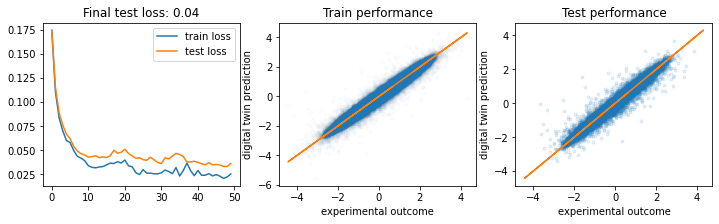

In [13]:
pendula.dt.train_mean_dt(
    Model = DNN,
    Nunits = [714, 605, 417, 201],
    lr = 0.005,
    epochs = 50)

The closer the blue points lie to the orange line, the more accurate the model has learned the experiment.

Alternatively, an architecture search can be performed by setting 
```Python
NAS = True
```
In this case, [Optuna](https://optuna.readthedocs.io/en/stable/index.html#) needs to be installed. 
An Optuna objective, defined in [model_architectures/DNN.py] needs to be provided and the number of architectures to be sampled needs to be defined with `Ntrials`. The cell below shows example code of how we could perform architecture search.

```Python
pendula.dt.train_mean_dt(
    Model = DNN,
    NAS = True, 
    Objective = DNNObjective,
    Ntrials = 100,
    epochs = 60,
)
```

### (Optional) Test digital twin on unseen data:

Contrary to the above graphs, on the next graph we test the digital twin with fixed parameters and uniformly distributed inputs. This usually means that a larger bias on the experimental output vs. digital model prediction will be present:

In [14]:
x = torch.FloatTensor(1000, pendula.input_dim).uniform_(*pendula.input_range).to(device)
with torch.no_grad():
    yexp = pendula(x).cpu()
    ypred = pendula.dt_physical(x).cpu()

In [15]:
def plot_dt_exp_comparison(yexp, ypred, index1 = 0, index2 = 1, module = None):
    plt.figure(figsize = [10,4], dpi = 100)

    plt.subplot(1,2,1)
    plt.plot(yexp.flatten(), ypred.flatten(), '.', alpha = 0.01)
    plt.plot(yexp.flatten(), yexp.flatten(), '-')
    plt.xlabel('experimental outcome')
    plt.ylabel('digital twin prediction')
    plt.title('Experimental outcomes vs predictions for all indices')
    plt.grid()

    plt.subplot(1,2,2)
    plt.plot(ypred[index1], '.-', lw = 1, c = 'b', alpha = 0.5, label = 'digital twin prediction')
    plt.plot(yexp[index1], 'x-', lw = 1, c = 'b', alpha = 0.5, label = 'experimental outcome')
    plt.plot(ypred[index2], '.-', lw = 1, c = 'r', alpha = 0.5)
    plt.plot(yexp[index2], 'x-', lw = 1, c = 'r', alpha = 0.5)
    plt.legend()
    if module:
        plt.ylim(module.dt.B - 3*module.dt.A, module.dt.B + 3 * module.dt.A)
    plt.xlabel('output index')
    plt.ylabel('output value')
    plt.title(f'Outputs from index {index1} and {index2}')
    plt.grid()
    
    plt.savefig('img/coupled_pendula_dt_performance.png')
    plt.show()

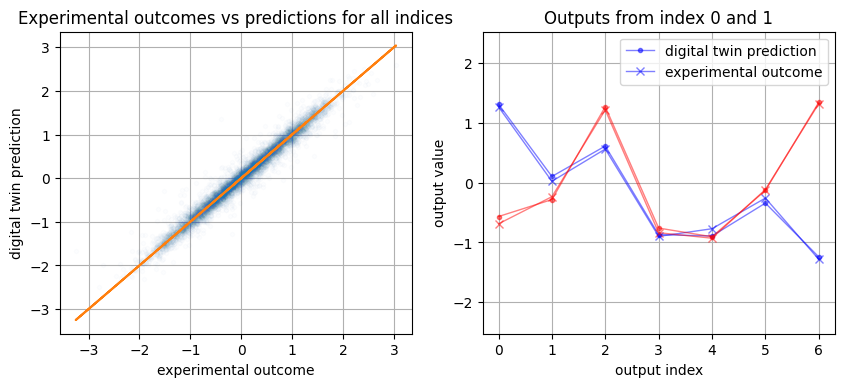

In [16]:
plot_dt_exp_comparison(yexp, ypred, module = pendula)

Again, the closer the blue points are to orange line on the left, the more accurate the digital twin is. On the right, we can see the experimental and predicted final angles for all 7 pendula for two different sets of initial conditions. If the two red lines and the two blue lines are significantly closer to each other than the red line is to the blue line, the digital model has a predictive power that exceeds the differences between different trials.

### (Optional) Explore physical systems expressivity

We will now explore how expressive each parameter of the physical system is. In the following plots, we set all parameters to a fixed value (0.75) and then sweep each individual input/parameter over its full range. For each of these sweeps, we then plot all outputs to see how each individual input affects all outputs.

The dashed lines show what the digital model predicts for each output, the solid lines show the experimental outcomes. The closer equally colored lines are to each other, the more accurate the predictions. The more nonlinear the shape of solid line, the more nonlinear is the influence of the corresponding parameter. The more outputs are changing at once, the more coupling between parameters exists.

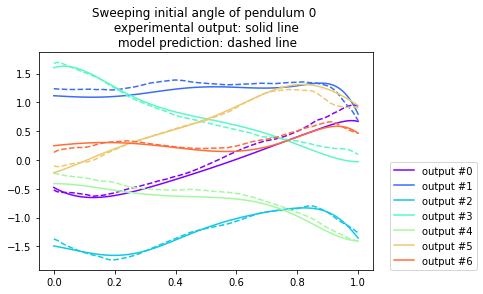

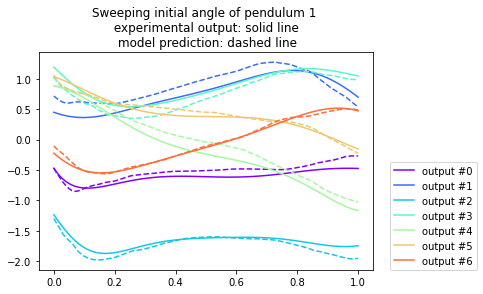

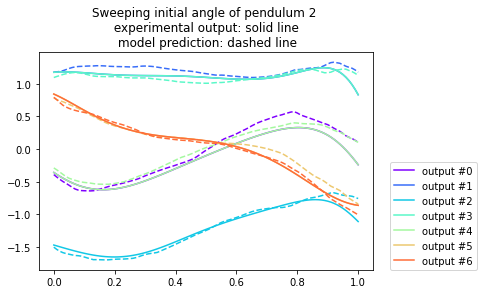

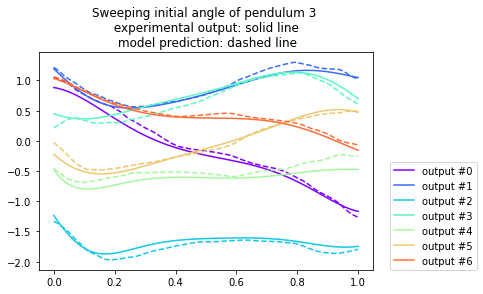

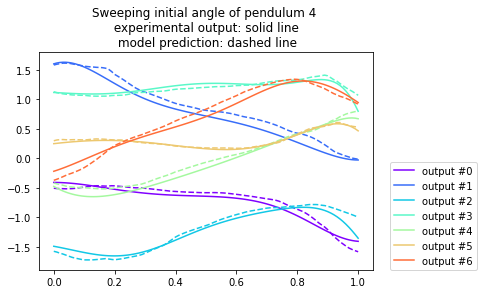

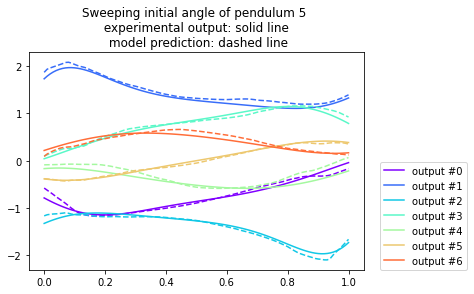

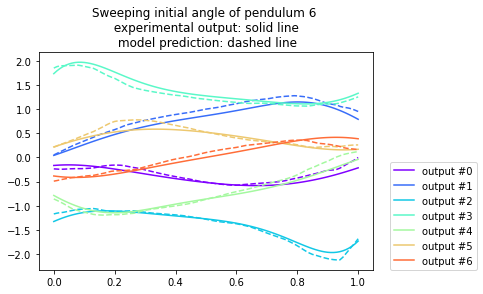

In [17]:
Nx = 101
for j in range(pendula.input_dim + pendula.ntrainableparams):
    # prepare input data with all parameters at a fixed value,
    # except the one at index being sweeped over the full allowed range
    x = 0.75*torch.ones(Nx, pendula.input_dim + pendula.ntrainableparams).to(pendula.device)
    x[:,[0, 2, 4]] = 0.25
    xsweep = torch.linspace(0,1,Nx)
    x[:,j] = xsweep
    
    # propagate inputs through experiment and digital twin
    yexp= pendula.exp_normalized(x)
    with torch.no_grad():
        ypred = pendula.dt(x)
    

    for i in range(pendula.output_dim):
        plt.plot(
            xsweep, yexp[:,i].cpu(), '-', 
            c = cm.rainbow(i/pendula.output_dim), 
            label = f'output #{i}')
        plt.plot(
            xsweep, ypred[:,i].cpu(), '--', 
            c = cm.rainbow(i/pendula.output_dim)) 
    plt.title(f"Sweeping initial angle of pendulum {j} \n experimental output: solid line \n model prediction: dashed line")
    plt.legend(loc = [1.05,0])
    plt.show()

## Single layer physical neural network

In this section we define a `pnn.Module`, a subclass of `torch.nn.Module` that defines the physical neural network architecture. Here, we define a single-layer coupled pendula network, meaning the whole computation is done during just one experimental execution.

As shown in the graph below, 2-dimensional inputs are encoded in the initial angles of the red pendula. The initial position of the orange pendula are trainable parameters of the PNN and the PNN's output is the final angle of the central pendulum after evolving for `Tmax`.

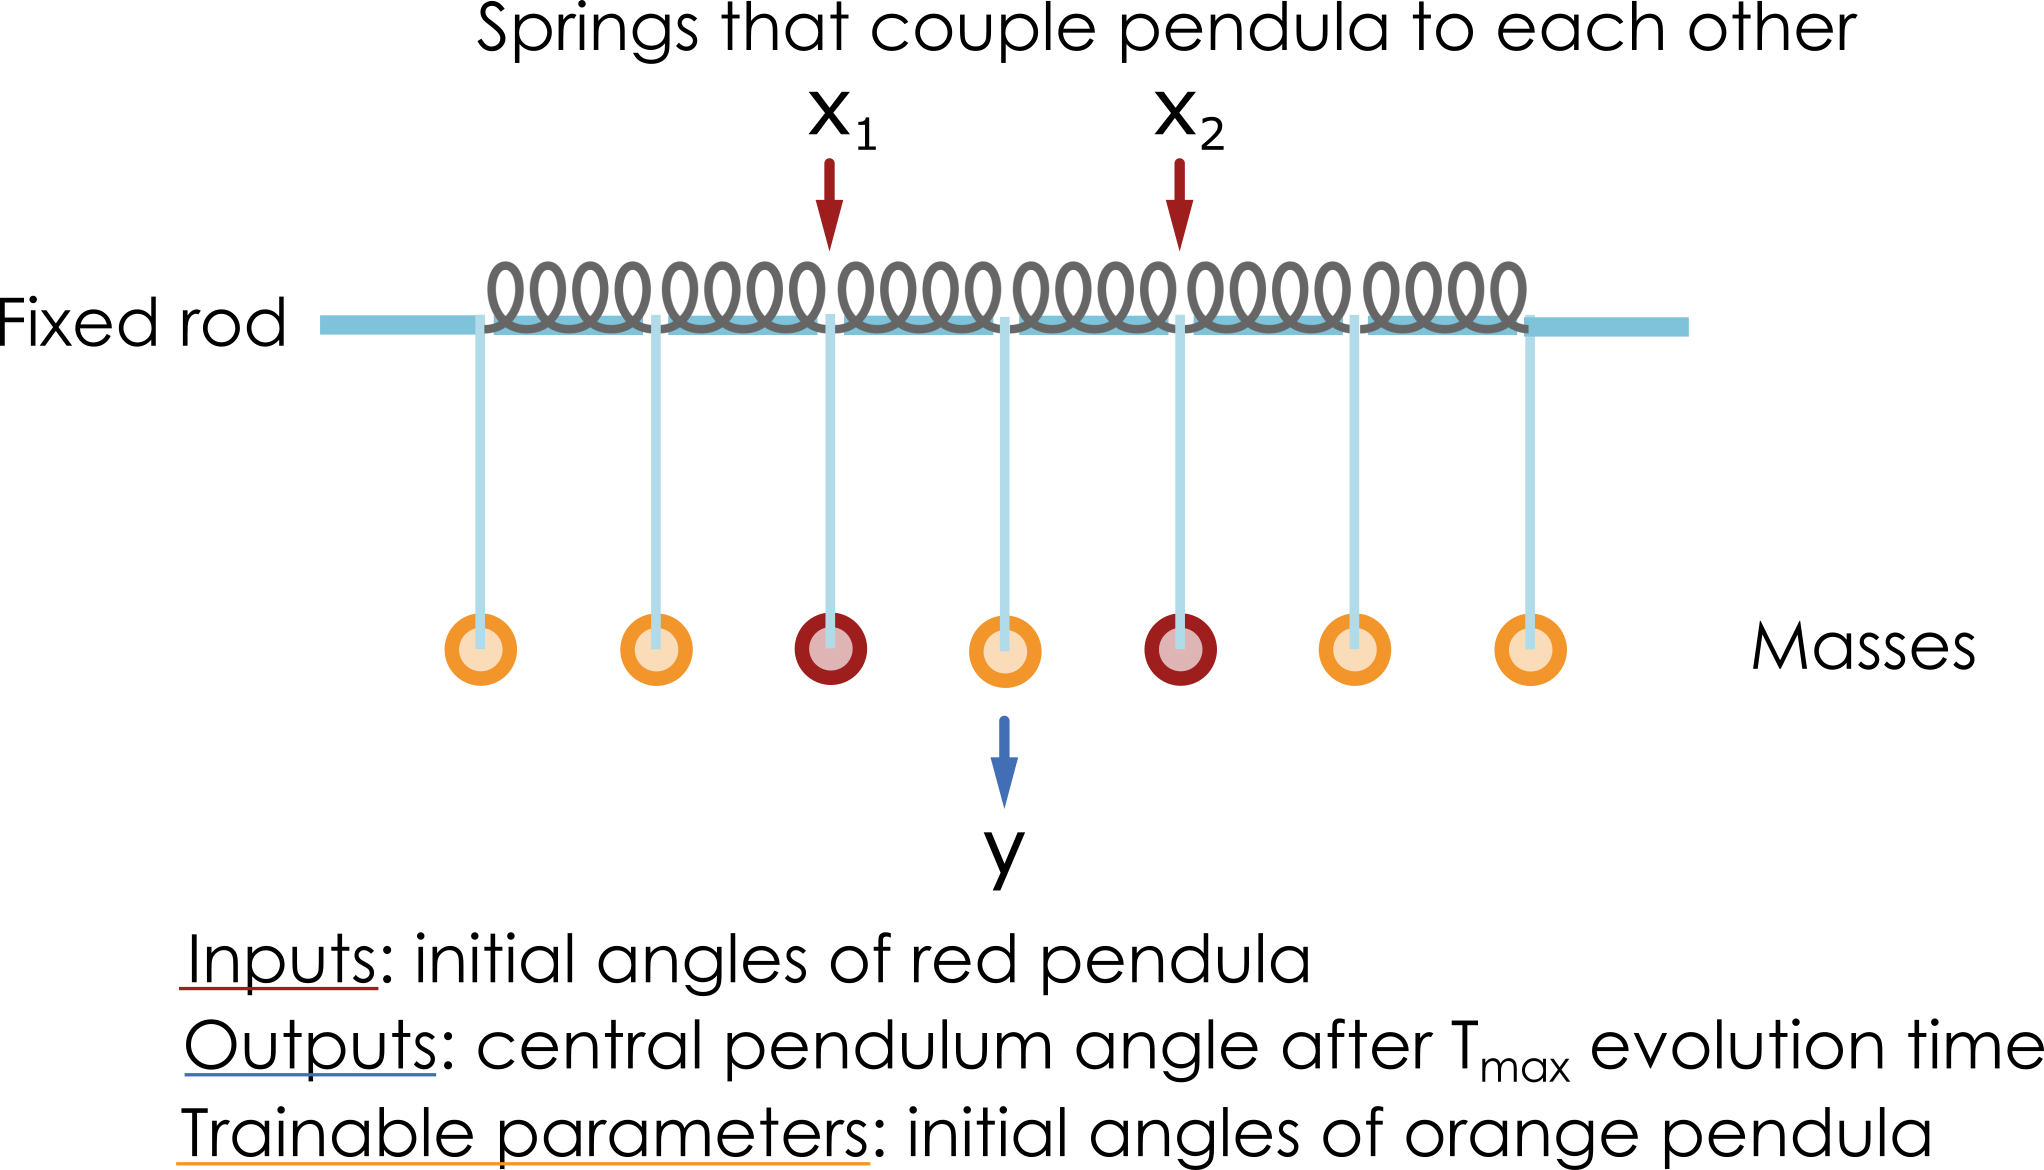

### Define PNN module

In [18]:
# this module contains the pnn.Module class
from physics_aware_training import pnn 

In [19]:
class PendulumNet(pnn.Module):
    '''
    This class represents the Physical Neural Network. It registers all
    PNN and regular pytorch modules.
    '''
    def __init__(self):
        super(pnn.Module, self).__init__()
        
        # n_pendula and pendulaargs are the variables we have defined above when 
        # training the differentiable digital model. As we have already trained a
        # digital model for this set of parameters, we can set 'load_dt = True'.
        self.dim = n_pendula
        self.pendula = ExpModule(**pendulaargs, load_dt = True)
        
        # Randomlize the initial positions of the control pendula:
        self.readout = pnn.Parameter(
            torch.rand(1, device = device)*np.pi-np.pi/2, requires_grad=True, limits = [-1.2, 1.2])
        self.left_control = pnn.Parameter(
            torch.rand(int(self.dim/2)-1, device = device)*np.pi-np.pi/2, requires_grad=True, limits = [-1.2, 1.2])
        self.right_control = pnn.Parameter(
            torch.rand(int(self.dim/2)-1, device = device)*np.pi-np.pi/2, requires_grad=True, limits = [-1.2, 1.2])
        
        # This parameter trains at which amplitude inputs are encoded and hence controls
        # the amount of nonlinearity in the input-output transformation.
        self.input_scaling = nn.Parameter(torch.tensor(1., device = device), requires_grad = True)
        
        # These two parameters define the decision boundary for the central pendula. 
        # Depending on whether the final angle is larger or smaller than the offset, 
        # the data is classified into one of the two classes. The scaling parameter
        # sets the softmax temperature to improve training but does not affect the 
        # final classification.
        self.scaling = nn.Parameter(torch.tensor(1., device = device), requires_grad=True)
        self.offset = nn.Parameter(torch.tensor(0., device = device), requires_grad=True)
        
        self.param_buffer = []
        

    def forward(self, x):
        batch_size = x.shape[0]
        
        # rescale inputs
        x = x*self.input_scaling
        
        # concatenate controls and inputs
        x = torch.cat((self.left_control.repeat(batch_size,1),
                       x[:,[0]],
                       self.readout.repeat(batch_size,1),
                       x[:,[1]],
                       self.right_control.repeat(batch_size,1)
                      ), dim = 1)
        
        # evolve inputs through the experiment
        x = self.pendula(x)
        
        # read output on the central pendulum
        x = x[:,int(self.dim/2)]
        
        # translate into log_softmax value
        x = torch.sigmoid(self.scaling*x - self.offset)
        x = torch.stack((x,1-x), dim = 1)
        output = torch.log(x)
        return output
    
    def save_params(self):
        # create copy of parameters
        params = dict(self.pendula.params)
        # move all parameters to cpu
        for key, val in params.items():
            params[key] = val.cpu().detach()
        # save in buffer
        self.param_buffer.append(params)

### Train PNN module

We train the above defined single-layer physical neural network on a simple, but linearly inseparable, 2-dimensional task. Here we define the dataset.

#### Initialize simple dataset

In [20]:
# Import simple precoded datasets
from physics_aware_training.datasets import Quadrants, AngledLine, Stripe, Circle

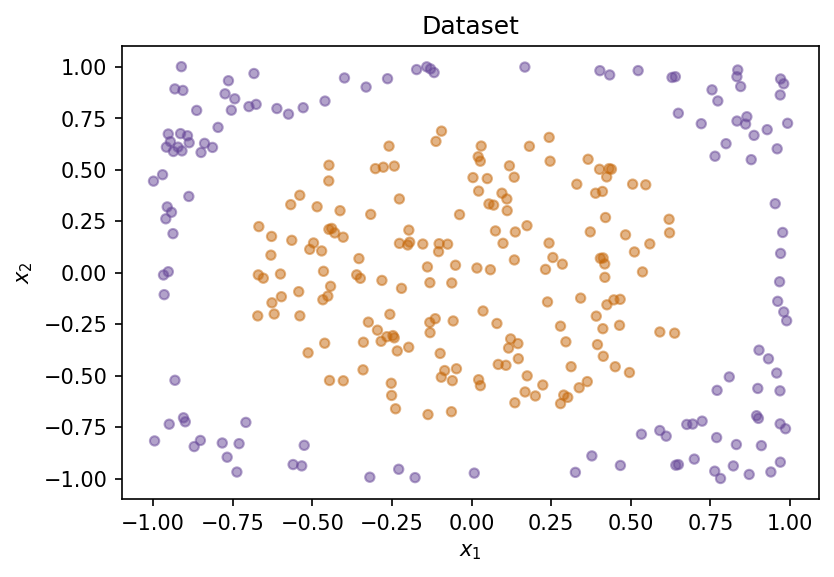

In [21]:
train_batch_size = 100
test_batch_size = 300

train_kwargs = {'batch_size': train_batch_size}
test_kwargs = {'batch_size': test_batch_size}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

dataset = Circle(n = 300)
dataset.plot()

train_loader = torch.utils.data.DataLoader(dataset, **train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset, **test_kwargs)

To solve this dataset, a physical algorithm equivalent to 

1. Compute $z = x_1^2 + x_2^2$
2. Blue if $z>0.7$, yellow if $z\leq0.7$

has to be found. To learn an equivalent physical algorithm, we next initialize the physical neural network, the optimizer we want to use and a learning rate schedule.

#### Initialize model, optimizer and scheduler

In [22]:
epochs = 30 
# log_interval determines after how many batches the losses are logged
log_interval = 1
lr = 0.01

In [23]:
model = PendulumNet().to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=100, gamma=0.3)

Loaded digital twin  diff_digital_models\CoupledPendula_mean_in7_out7_Tmax2.0.p


In [24]:
# Initialize empty lists to store training process during training loop
model_by_step = []

batch_idx_ls = []
acc_ls = []
cr_loss_ls = []
lg_loss_ls = []
test_ls = []
test_accs = []

#### Training loop

The training loop is a regular pytorch training loop, the only difference being that an additional 'lagrangian loss' `lg_loss` is computed that retains trainable parameters within the bounds set for the `ExpModule`.

In [25]:
for epoch in range(1, epochs + 1):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)

        # the only addition to a conventional pytorch training loop is the lagrangian loss term
        # that keeps parameters and inputs within the user-defined ranges
        lg_loss = model.pnnlagrangian()
        cr_loss = F.nll_loss(output, target)
        loss = lg_loss + cr_loss

        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            batch_idx_ls.append(epoch + batch_idx / len(train_loader))
            cr_loss_ls.append(cr_loss)
            lg_loss_ls.append(lg_loss)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct = pred.eq(target.view_as(pred)).sum().item()
            acc_ls.append(correct / len(target))
            
            # save the current state dict to later visualize training
            model_by_step.append(pnn.get_cpu_state_dict(model))
    
    test_loss, acc = model.test_epoch(device, test_loader)
    scheduler.step()
    test_ls.append(test_loss)
    test_accs.append(acc)
    print(f'Finished epoch {epoch} with test loss {test_loss:.2f} and accuracy {int(acc*100)}.')

# The warning is discussed here and seems to be an issue that is fixed in pytorch 1.8 but not in
# pytorch 1.7.1
# https://github.com/pytorch/pytorch/issues/46983

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:552: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Finished epoch 1 with test loss 0.78 and accuracy 43.
Finished epoch 2 with test loss 0.75 and accuracy 43.
Finished epoch 3 with test loss 0.72 and accuracy 43.
Finished epoch 4 with test loss 0.70 and accuracy 43.
Finished epoch 5 with test loss 0.68 and accuracy 43.
Finished epoch 6 with test loss 0.67 and accuracy 43.
Finished epoch 7 with test loss 0.65 and accuracy 43.
Finished epoch 8 with test loss 0.64 and accuracy 66.
Finished epoch 9 with test loss 0.63 and accuracy 77.
Finished epoch 10 with test loss 0.62 and accuracy 86.
Finished epoch 11 with test loss 0.62 and accuracy 92.
Finished epoch 12 with test loss 0.61 and accuracy 92.
Finished epoch 13 with test loss 0.60 and accuracy 92.
Finished epoch 14 with test loss 0.59 and accuracy 93.
Finished epoch 15 with test loss 0.59 and accuracy 93.
Finished epoch 16 with test loss 0.58 and accuracy 94.
Finished epoch 17 with test loss 0.57 and accuracy 95.
Finished epoch 18 with test loss 0.57 and accuracy 95.
Finished epoch 19 w

### Visualize results

We plot the training and testing loss over epoch, the test accuracy over epoch and a visualization of what the physical neural network predicts for every point in the 2D plane.

In [26]:
def visualize_training(test_ls, lg_loss_ls, cr_loss_ls, test_accs, train_loader, epochs, log_interval, dataset):
    steps = torch.arange(0, epochs, 1/len(train_loader)/log_interval)
    nsteps = epochs * len(train_loader) / log_interval
    plt.figure(figsize = [12,4], dpi = 100)

    plt.subplot(1,3,1)
    plt.plot(steps, cr_loss_ls, label = 'cross entropy train loss')
    plt.plot(steps, lg_loss_ls, label = 'lagrangian train loss')
    plt.plot(test_ls, label = 'test loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('validation loss')
    plt.title('Loss over epoch')
    plt.ylim(0, 1)

    plt.subplot(1,3,2)
    plt.plot(test_accs)
    plt.xlabel('epoch')
    plt.ylabel('validation accuracy')
    plt.title('Test accuracy over epoch')


    # determine the resolution of the PNN prediction subplot
    res = 30
    x = torch.linspace(-1, 1, res)
    y = torch.linspace(-1, 1, res)
    xx, yy = torch.meshgrid(x, y)
    # find what the PNN predicts for all points in the 2D plane.
    with torch.no_grad():
        out = model(torch.stack((xx.flatten(), yy.flatten())).t().to(device))
    out = torch.softmax(out, dim = -1)[:,1].reshape(res,res).cpu()

    plt.subplot(1,3,3)
    plt.title('PNN predictions')

    # plot PNN predictions
    plt.contourf(xx, yy, out, 100, cmap = cm.PuOr, vmin = -0.2, vmax = 1.2, alpha = 0.7, antialiased = True)
    # plt.contour(xx, yy, out, [0.5], color = ['black'], linewidths = 0.3)

    # plot data points on top
    xdata = dataset[:][0].to(device)
    ydata = dataset[:][1].to(device)
    plt.scatter(xdata[:,0].cpu(), xdata[:,1].cpu(), c = ydata.cpu(), s = 20, cmap = cm.PuOr, alpha = 0.5, vmin = -0.2, vmax = 1.2)

    plt.tight_layout()

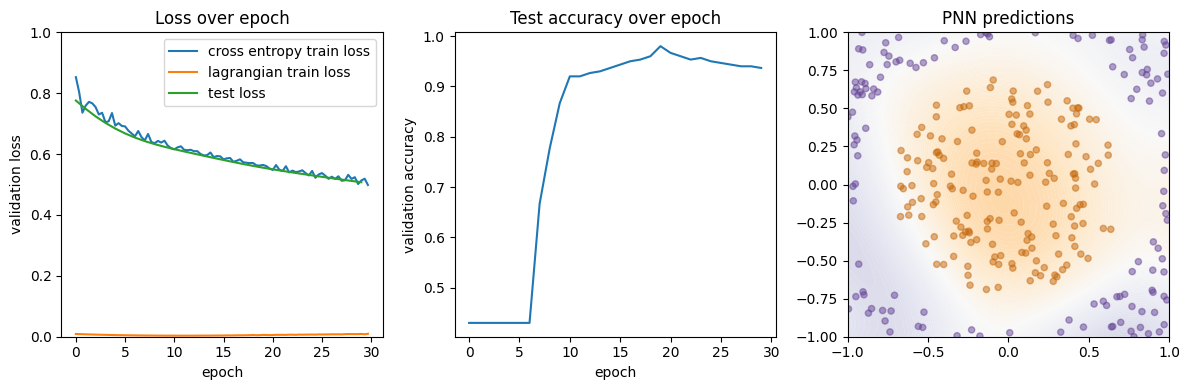

In [27]:
visualize_training(test_ls, lg_loss_ls, cr_loss_ls, test_accs, train_loader, epochs, log_interval, dataset)

The predictions of the physical neural network closely match the circular shape of the point clouds. In the next section, we show how to create a more versatile multi-layer physical neural network that can solve several nonlinear classification tasks in the 2D plane.

### Save data

In [28]:
np.savez('img/single_layer_training_data.npz',
        pendulaargs = pendulaargs,
        model_by_step = model_by_step,
        acc_ls = acc_ls,
        cr_loss_ls = cr_loss_ls,
        lg_loss_ls = lg_loss_ls,
        test_ls = test_ls,
        test_accs = test_accs,
        log_interval = log_interval,
        train_batch_size = train_batch_size,
        test_batch_size = test_batch_size,
        epochs = len(test_ls))

## Multilayer physical neural network

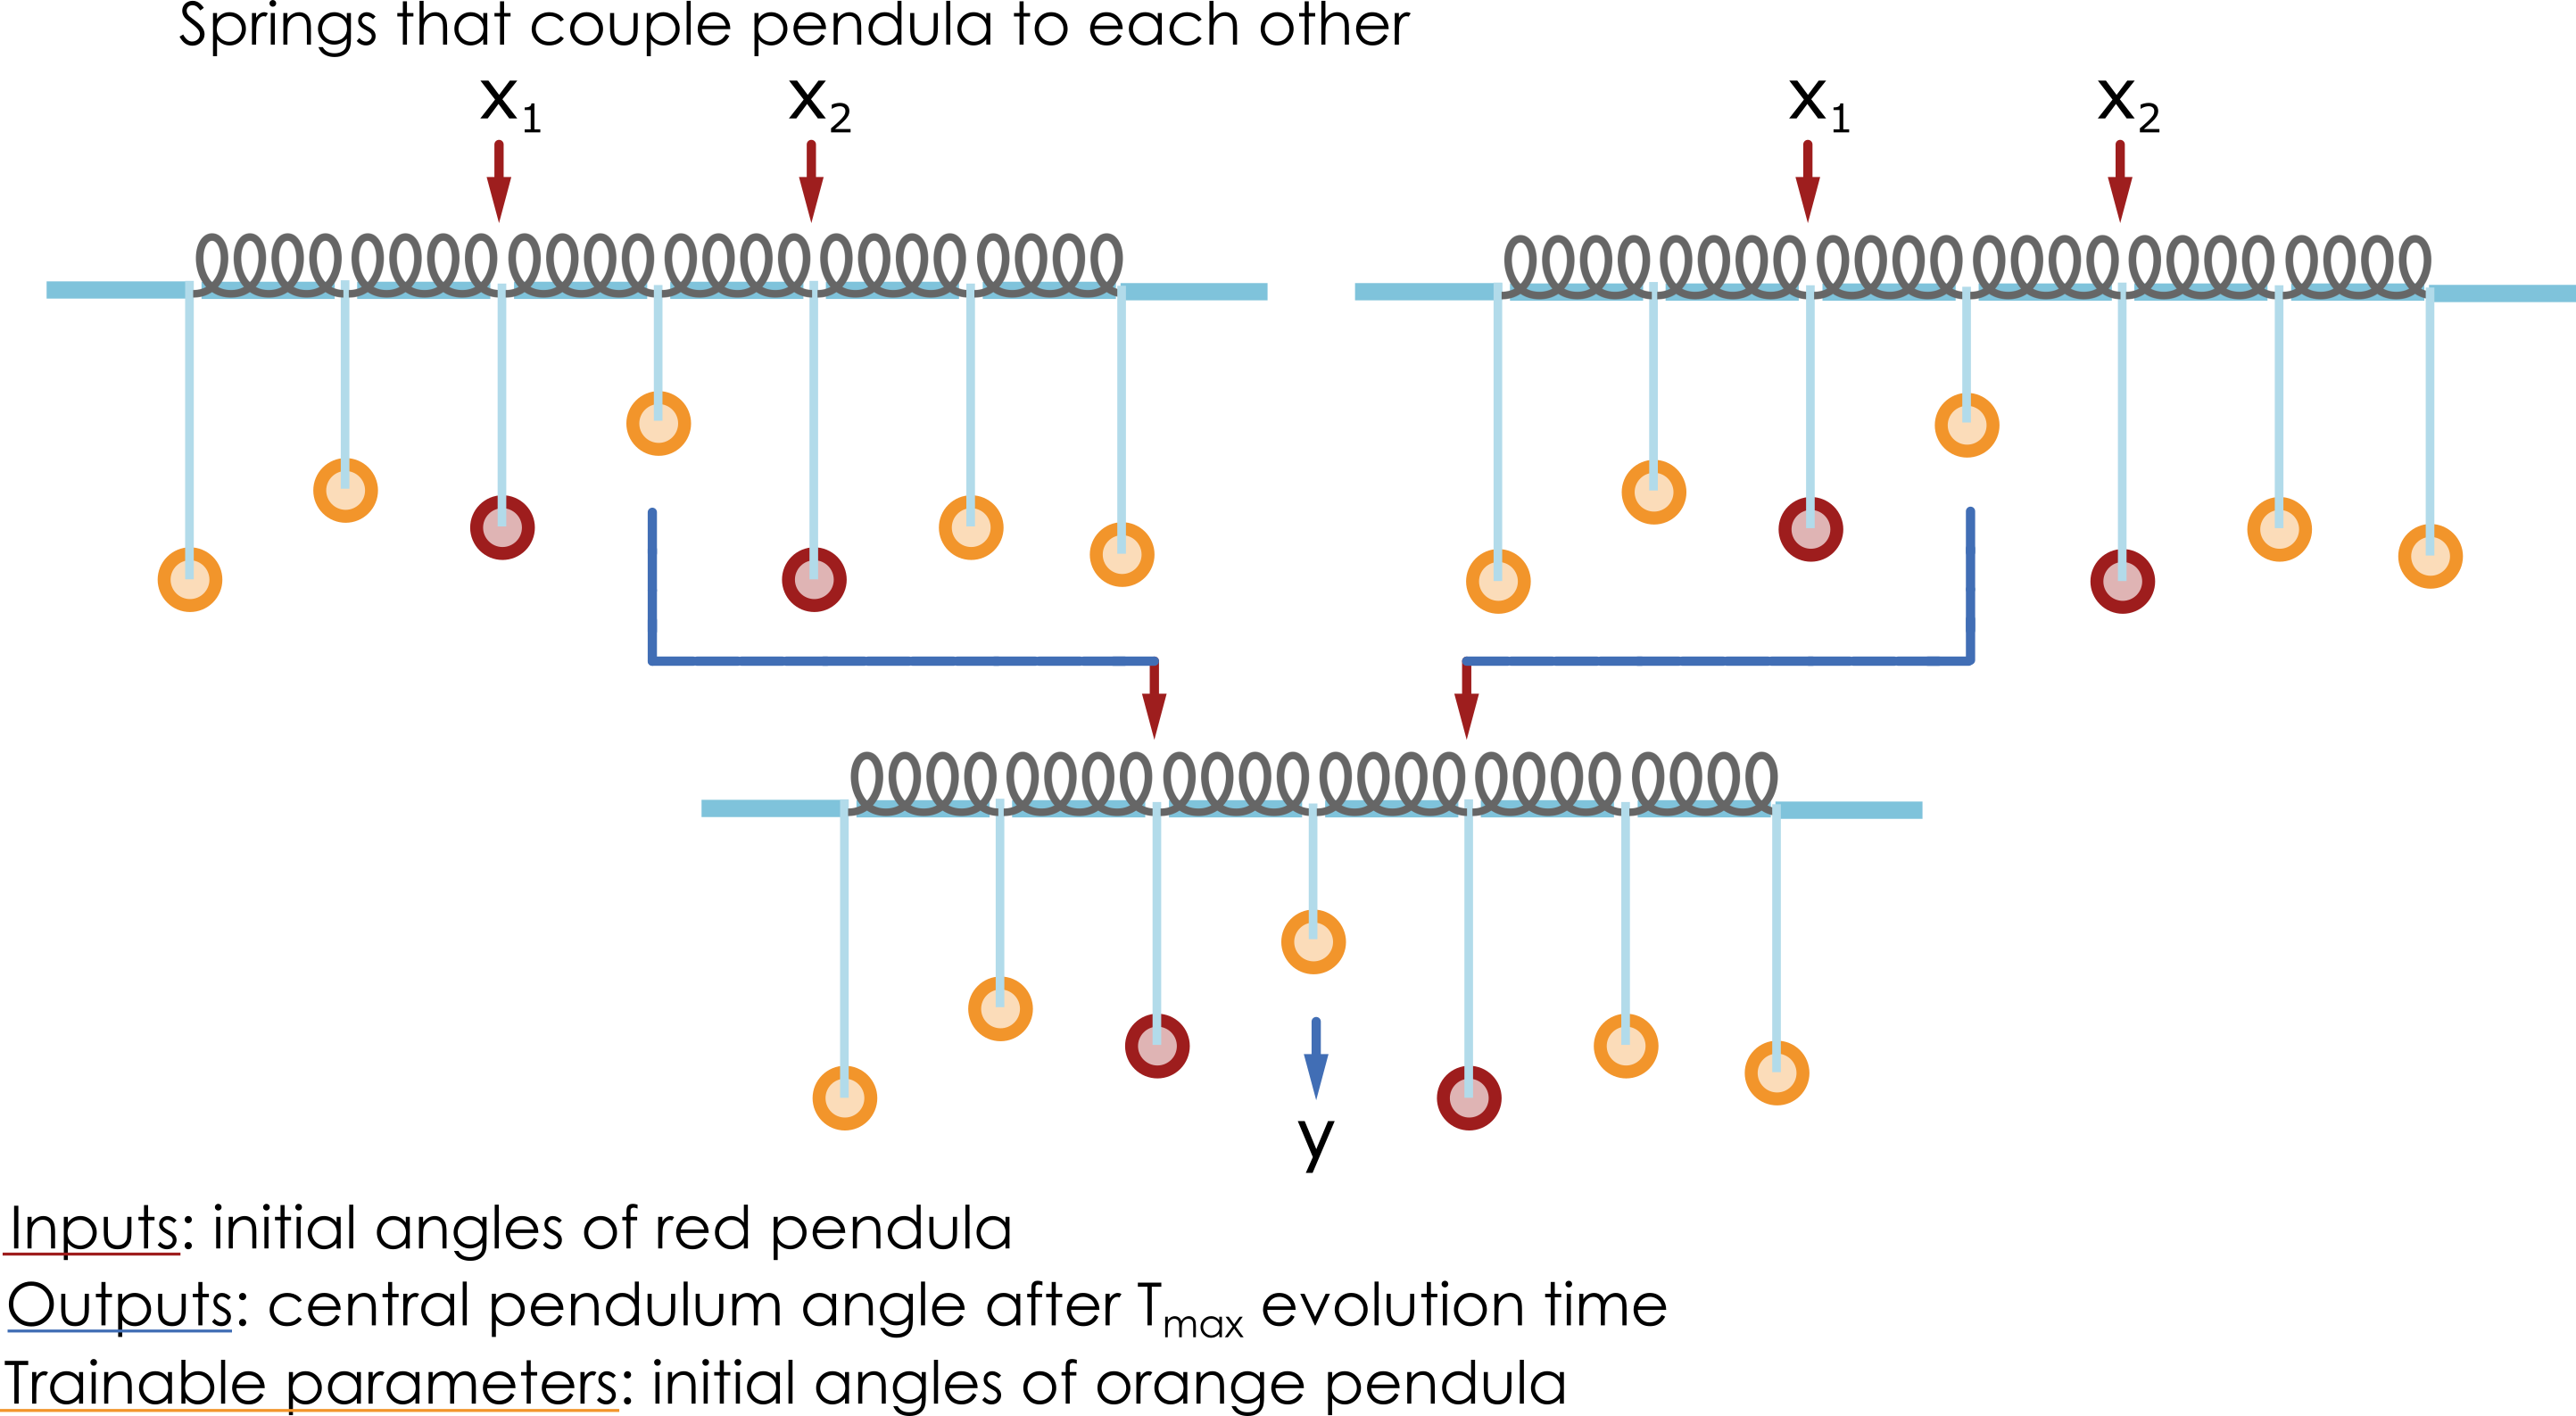

In this section, we define a multi-layer physical neural network consisiting of 3 setups of coupled pendula. Inputs are fed into two setups of coupled pendula in parallel and the outputs from both setups are then combined in the last setup.

We also introduce heterogeneity in the parameters of the pendula. We can improve the network's prediction by setting the natural frequencies and coupling constants between pendula to different values.

### Define multilayer architecture

In [29]:
pendulaargs['hparams']['Tmax'] = 5.0
pendulaargs['input_range'] = [-0.5*np.pi, 0.5*np.pi]

In [30]:
class MLPendulaNet(pnn.Module):
    '''
    This class represents the Multilayer Pendulum Physical Neural Network.
    '''
    def __init__(self):
        super(pnn.Module, self).__init__()
        
        # Define the first coupled pendula setup:
        self.dim = n_pendula
        self.pendula1 = ExpModule(**pendulaargs, load_dt = True)
        # set the natural frequencies and coupling constants to random values
        # to introduce heterogeneity:
        self.pendula1.fixed_params['ω0'] = torch.rand(7, device = 'cuda:0')*10 + 5
        self.pendula1.fixed_params['coupling'] = torch.rand(7, device = 'cuda:0')*20 + 10

        # since the newly introduced heterogeneity changes the system's behavior we need
        # to retrain the digital model:
        self.pendula1.dt.take_dt_data(50000)
        self.pendula1.dt.train_mean_dt(
            Model = DNN,
            Nunits = [714, 605, 417, 201],
            lr = 0.005,
            epochs = 50)
        
        # Repeat this procedure for the second coupled pendula setup:
        self.pendula2 = ExpModule(**pendulaargs, load_dt = True)
        self.pendula2.fixed_params['ω0'] = torch.rand(7, device = 'cuda:0')*10 + 5
        self.pendula2.fixed_params['coupling'] = torch.rand(7, device = 'cuda:0')*20 + 10

        self.pendula2.dt.take_dt_data(50000)
        self.pendula2.dt.train_mean_dt(
            Model = DNN,
            Nunits = [714, 605, 417, 201],
            lr = 0.005,
            epochs = 50)
        
        # ...and the third one:
        self.pendula3 = ExpModule(**pendulaargs, load_dt = True)
        self.pendula3.fixed_params['ω0'] = torch.rand(7, device = 'cuda:0')*10 + 5
        self.pendula3.fixed_params['coupling'] = torch.rand(7, device = 'cuda:0')*20 + 10

        self.pendula3.dt.take_dt_data(50000)
        self.pendula3.dt.train_mean_dt(
            Model = DNN,
            Nunits = [714, 605, 417, 201],
            lr = 0.005,
            epochs = 50)
        
        # initialize variables for the initial angles of all control pendula in the setup:
        self.input_scaling = nn.Parameter(torch.tensor([1., 1., 1.], device = device), requires_grad=True)
        self.control = pnn.Parameter(
            torch.rand(3, 5, device = device)*np.pi-np.pi/2, requires_grad=True, limits = [-1.2, 1.2])
        
        # Define the final decision boundary
        self.scaling = nn.Parameter(torch.tensor(1., device = device), requires_grad=True)
        self.offset = nn.Parameter(torch.tensor(0., device = device), requires_grad=True)
        
        self.param_buffer = []
        

    def forward(self, x):
        batch_size = x.shape[0]
        
        # Pass inputs through the first setup:
        # -----------------------------------
        x1 = x * self.input_scaling[0]
        # concatenate controls and inputs
        x1 = torch.cat((self.control[0, :2].repeat(batch_size,1),
                       x1[:,[0]],
                       self.control[0, 2].repeat(batch_size,1),
                       x1[:,[1]],
                       self.control[0, 3:5].repeat(batch_size,1)
                      ), dim = 1)
        
        x1 = self.pendula1(x1)
        
        # read out on one of the central pendulum
        x1 = x1[:,int(self.dim/2)]
        
        # Pass inputs through the second setup:
        # -----------------------------------
        x2 = x * self.input_scaling[1]
        x2 = torch.cat((self.control[1, :2].repeat(batch_size,1),
                       x2[:,[0]],
                       self.control[1, 2].repeat(batch_size,1),
                       x2[:,[1]],
                       self.control[1, 3:5].repeat(batch_size,1)
                      ), dim = 1)
        
        x2 = self.pendula2(x2)
        
        x2 = x2[:,int(self.dim/2)]
        
        # Pass inputs through the third setup:
        # -----------------------------------
        x3 = torch.cat((self.control[2, :2].repeat(batch_size,1),
                       self.input_scaling[2]*x1.unsqueeze(-1),
                       self.control[2, 3].repeat(batch_size,1),
                       self.input_scaling[2]*x2.unsqueeze(-1),
                       self.control[2, 3:5].repeat(batch_size,1)
                      ), dim = 1)
        
        x3 = self.pendula3(x3)
        
        # read out on the central pendulum
        x3 = x3[:,int(self.dim/2)]
        
        x3 = torch.sigmoid(self.scaling*x3 - self.offset)
        x3 = torch.stack((x3,1-x3), dim = 1)
        output = torch.log(x3)
        return output
    
    def save_params(self):
        # create copy of parameters
        params = dict(self.pendula.params)
        # move all parameters to cpu
        for key, val in params.items():
            params[key] = val.cpu().detach()
        # save in buffer
        self.param_buffer.append(params)

### Test on circle dataset

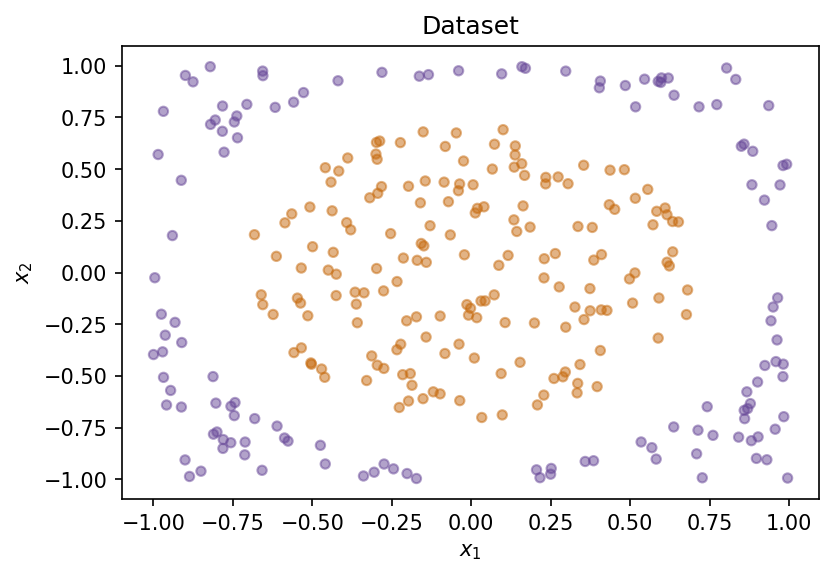

In [31]:
train_batch_size = 100
test_batch_size = 300

train_kwargs = {'batch_size': train_batch_size}
test_kwargs = {'batch_size': test_batch_size}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

dataset = Circle(n = 300)
dataset.plot()

train_loader = torch.utils.data.DataLoader(dataset, **train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset, **test_kwargs)

Initialize the model: This PendulumNet consists of three coupled pendula experiments. For all of them a differentiable digital model will be trained.

Loaded digital twin  diff_digital_models\CoupledPendula_mean_in7_out7_Tmax5.0.p
Saved data exp_io_data\CoupledPendula_mean_in7_out7_Tmax5.0_data.npz
Loaded data exp_io_data\CoupledPendula_mean_in7_out7_Tmax5.0_data.npz
Epoch: 1, 	 Train loss: 0.65, 	 Test loss: 0.64
Epoch: 2, 	 Train loss: 0.47, 	 Test loss: 0.49
Epoch: 3, 	 Train loss: 0.30, 	 Test loss: 0.29
Epoch: 4, 	 Train loss: 0.21, 	 Test loss: 0.24
Epoch: 5, 	 Train loss: 0.17, 	 Test loss: 0.18
Epoch: 6, 	 Train loss: 0.16, 	 Test loss: 0.16
Epoch: 7, 	 Train loss: 0.15, 	 Test loss: 0.17
Epoch: 8, 	 Train loss: 0.13, 	 Test loss: 0.15
Epoch: 9, 	 Train loss: 0.13, 	 Test loss: 0.15
Epoch: 10, 	 Train loss: 0.12, 	 Test loss: 0.15
Epoch: 11, 	 Train loss: 0.11, 	 Test loss: 0.13
Epoch: 12, 	 Train loss: 0.12, 	 Test loss: 0.14
Epoch: 13, 	 Train loss: 0.11, 	 Test loss: 0.14
Epoch: 14, 	 Train loss: 0.10, 	 Test loss: 0.13
Epoch: 15, 	 Train loss: 0.09, 	 Test loss: 0.12
Epoch: 16, 	 Train loss: 0.09, 	 Test loss: 0.12
Epoch:

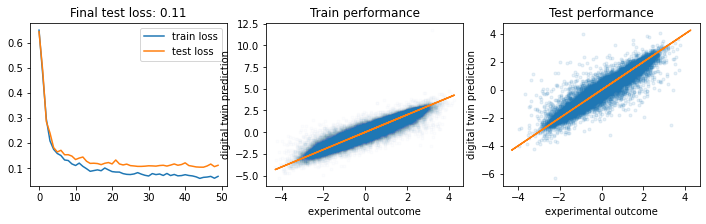

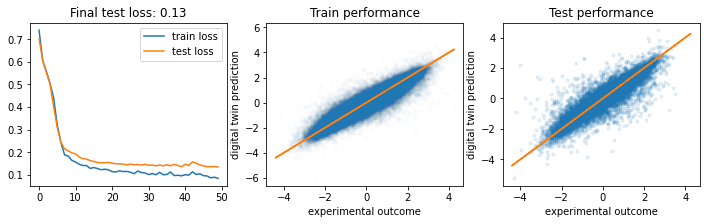

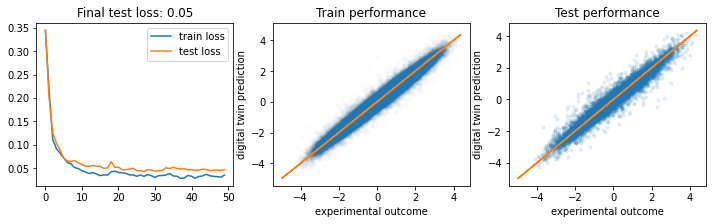

In [32]:
model = MLPendulaNet().to(device)

Set training parameters for the physical neural network training loop:

In [33]:
lr = 0.05
epochs = 50
log_interval = 1

In [34]:
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=100, gamma=0.3)

Initialize empty lists that save the training progress:

In [35]:
model_by_step = []

batch_idx_ls = []
acc_ls = []
cr_loss_ls = []
lg_loss_ls = []
test_ls = []
test_accs = []

Train the multilayer network with the same training loop as the single-layer network:

In [36]:
for epoch in range(1, epochs + 1):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)

        # the only addition to a conventional pytorch training loop is the lagrangian loss term
        # that keeps parameters and inputs within the user-defined ranges
        lg_loss = model.pnnlagrangian()
        cr_loss = F.nll_loss(output, target)
        loss = lg_loss + cr_loss

        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            batch_idx_ls.append(epoch + batch_idx / len(train_loader))
            cr_loss_ls.append(cr_loss)
            lg_loss_ls.append(lg_loss)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct = pred.eq(target.view_as(pred)).sum().item()
            acc_ls.append(correct / len(target))

            # save the current state dict to later visualize training
            model_by_step.append(pnn.get_cpu_state_dict(model))

    test_loss, acc = model.test_epoch(device, test_loader)
    scheduler.step()
    test_ls.append(test_loss)
    test_accs.append(acc)
    print(f'Finished epoch {epoch} with test loss {test_loss:.2f} and accuracy {int(acc*100)}.')

# The warning is discussed here and seems to be an issue that is fixed in pytorch 1.8 but not in
# pytorch 1.7.1
# https://github.com/pytorch/pytorch/issues/46983

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:552: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Finished epoch 1 with test loss 0.64 and accuracy 82.
Finished epoch 2 with test loss 0.61 and accuracy 82.
Finished epoch 3 with test loss 0.59 and accuracy 71.
Finished epoch 4 with test loss 0.54 and accuracy 81.
Finished epoch 5 with test loss 0.50 and accuracy 81.
Finished epoch 6 with test loss 0.48 and accuracy 81.
Finished epoch 7 with test loss 0.46 and accuracy 82.
Finished epoch 8 with test loss 0.43 and accuracy 83.
Finished epoch 9 with test loss 0.39 and accuracy 84.
Finished epoch 10 with test loss 0.35 and accuracy 87.
Finished epoch 11 with test loss 0.36 and accuracy 85.
Finished epoch 12 with test loss 0.31 and accuracy 86.
Finished epoch 13 with test loss 0.32 and accuracy 86.
Finished epoch 14 with test loss 0.28 and accuracy 88.
Finished epoch 15 with test loss 0.24 and accuracy 90.
Finished epoch 16 with test loss 0.24 and accuracy 92.
Finished epoch 17 with test loss 0.23 and accuracy 92.
Finished epoch 18 with test loss 0.21 and accuracy 90.
Finished epoch 19 w

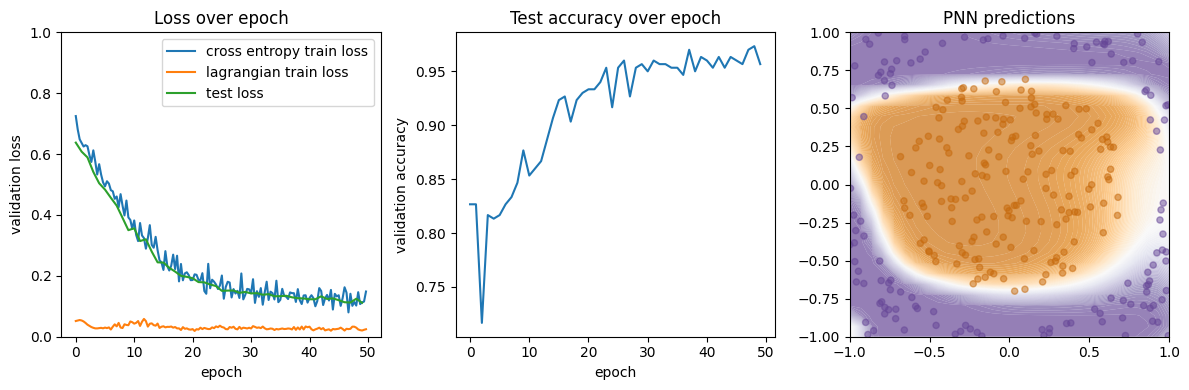

In [37]:
visualize_training(test_ls, lg_loss_ls, cr_loss_ls, test_accs, train_loader, epochs, log_interval, dataset)

### Test on stripe dataset

Now try the same network on a different dataset:

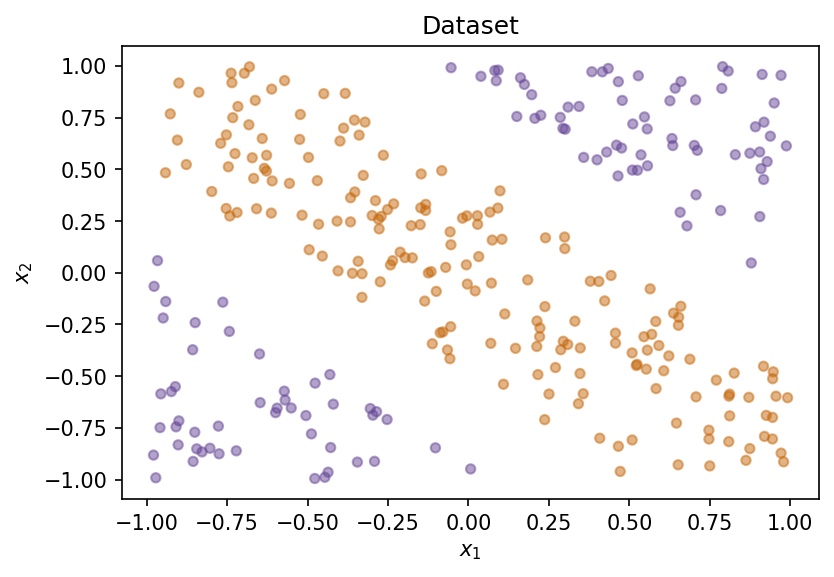

In [38]:
dataset = Stripe(n = 300)
dataset.plot()

train_loader = torch.utils.data.DataLoader(dataset, **train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset, **test_kwargs)

All trainable parameters of the PendulumNet are reset to random initializations:

In [39]:
# initialize more pendula that can be used as controls
model.readout1 = pnn.Parameter(
    torch.rand(1, device = device)*np.pi-np.pi/2, requires_grad=True, limits = [-1.2, 1.2])
model.left_control1 = pnn.Parameter(
    torch.rand(int(model.dim/2)-1, device = device)*np.pi-np.pi/2, requires_grad=True, limits = [-1.2, 1.2])
model.right_control1 = pnn.Parameter(
    torch.rand(int(model.dim/2)-1, device = device)*np.pi-np.pi/2, requires_grad=True, limits = [-1.2, 1.2])

model.readout2 = pnn.Parameter(
    torch.rand(1, device = device)*np.pi-np.pi/2, requires_grad=True, limits = [-1.2, 1.2])
model.left_control2 = pnn.Parameter(
    torch.rand(int(model.dim/2)-1, device = device)*np.pi-np.pi/2, requires_grad=True, limits = [-1.2, 1.2])
model.right_control2 = pnn.Parameter(
    torch.rand(int(model.dim/2)-1, device = device)*np.pi-np.pi/2, requires_grad=True, limits = [-1.2, 1.2])

model.readout3 = pnn.Parameter(
    torch.rand(1, device = device)*np.pi-np.pi/2, requires_grad=True, limits = [-1.2, 1.2])
model.left_control3 = pnn.Parameter(
    torch.rand(int(model.dim/2)-1, device = device)*np.pi-np.pi/2, requires_grad=True, limits = [-1.2, 1.2])
model.right_control3 = pnn.Parameter(
    torch.rand(int(model.dim/2)-1, device = device)*np.pi-np.pi/2, requires_grad=True, limits = [-1.2, 1.2])

# to define and rescale decision boundary
model.scaling = nn.Parameter(torch.tensor(1., device = device), requires_grad=True)
model.input_scaling1 = nn.Parameter(torch.tensor(1., device = device), requires_grad=True)
model.input_scaling2 = nn.Parameter(torch.tensor(1., device = device), requires_grad=True)
model.input_scaling3 = nn.Parameter(torch.tensor(1., device = device), requires_grad=True)
model.offset = nn.Parameter(torch.tensor(0., device = device), requires_grad=True)

In [40]:
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=100, gamma=0.3)

In [41]:
model_by_step = []

batch_idx_ls = []
acc_ls = []
cr_loss_ls = []
lg_loss_ls = []
test_ls = []
test_accs = []

In [42]:
for epoch in range(1, epochs + 1):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)

        # the only addition to a conventional pytorch training loop is the lagrangian loss term
        # that keeps parameters and inputs within the user-defined ranges
        lg_loss = model.pnnlagrangian()
        cr_loss = F.nll_loss(output, target)
        loss = lg_loss + cr_loss

        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            batch_idx_ls.append(epoch + batch_idx / len(train_loader))
            cr_loss_ls.append(cr_loss)
            lg_loss_ls.append(lg_loss)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct = pred.eq(target.view_as(pred)).sum().item()
            acc_ls.append(correct / len(target))

            # save the current state dict to later visualize training
            model_by_step.append(pnn.get_cpu_state_dict(model))

    test_loss, acc = model.test_epoch(device, test_loader)
    scheduler.step()
    test_ls.append(test_loss)
    test_accs.append(acc)
    print(f'Finished epoch {epoch} with test loss {test_loss:.2f} and accuracy {int(acc*100)}.')

# The warning is discussed here and seems to be an issue that is fixed in pytorch 1.8 but not in
# pytorch 1.7.1
# https://github.com/pytorch/pytorch/issues/46983

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:552: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Finished epoch 1 with test loss 0.41 and accuracy 86.
Finished epoch 2 with test loss 0.42 and accuracy 85.
Finished epoch 3 with test loss 0.38 and accuracy 87.
Finished epoch 4 with test loss 0.34 and accuracy 87.
Finished epoch 5 with test loss 0.34 and accuracy 86.
Finished epoch 6 with test loss 0.33 and accuracy 86.
Finished epoch 7 with test loss 0.31 and accuracy 88.
Finished epoch 8 with test loss 0.30 and accuracy 86.
Finished epoch 9 with test loss 0.31 and accuracy 87.
Finished epoch 10 with test loss 0.29 and accuracy 87.
Finished epoch 11 with test loss 0.29 and accuracy 87.
Finished epoch 12 with test loss 0.29 and accuracy 87.
Finished epoch 13 with test loss 0.28 and accuracy 87.
Finished epoch 14 with test loss 0.27 and accuracy 87.
Finished epoch 15 with test loss 0.26 and accuracy 89.
Finished epoch 16 with test loss 0.27 and accuracy 87.
Finished epoch 17 with test loss 0.29 and accuracy 86.
Finished epoch 18 with test loss 0.29 and accuracy 86.
Finished epoch 19 w

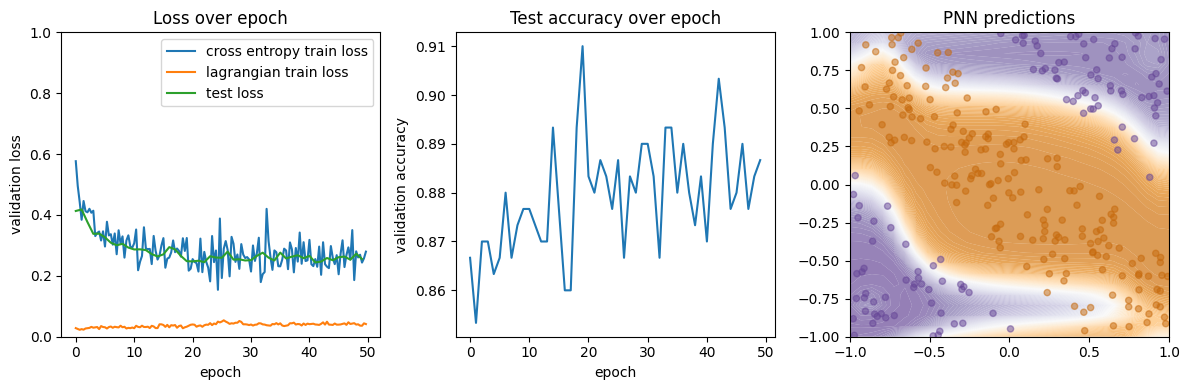

In [43]:
visualize_training(test_ls, lg_loss_ls, cr_loss_ls, test_accs, train_loader, epochs, log_interval, dataset)